## Embeddings 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

from dotenv import load_dotenv
import os

from tqdm import tqdm

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [2]:
embedding_size = 1536
embedding_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embedding_model, dimensions=embedding_size)

## Load data

In [3]:
file_path_ed_financeira = "../data/educacao_financeira.pdf"
file_path_historia = "../data/historia.pdf"
loader_historia = PyPDFLoader(file_path_historia)
loader_ed_financeira = PyPDFLoader(file_path_ed_financeira)
pages_historia = loader_historia.load()
pages_ed_financeira = loader_ed_financeira.load()

In [4]:
# Concatenante todo o conteudo em uma string só

all_content_pages_historia = "\n\n".join([page.page_content for page in pages_historia])
all_content_pages_ed_financeira = "\n\n".join([page.page_content for page in pages_ed_financeira])

## Text Splitter

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2_000,
    chunk_overlap=500,
    length_function=len,
    is_separator_regex=False,
)

In [6]:
chunks_historia = text_splitter.split_documents(pages_historia)
chunks_ed_financeira = text_splitter.split_documents(pages_ed_financeira)

## Criando embeddings

In [7]:
vectors_historia = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_historia]))

In [8]:
vectors_ed_financeira = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_ed_financeira]))

In [9]:
all_vectors = np.concatenate([vectors_historia, vectors_ed_financeira], axis=0)

In [10]:
vectors_ed_financeira.shape, vectors_historia.shape, all_vectors.shape

((227, 1536), (333, 1536), (560, 1536))

## Reduzindo a dimensionalidade

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
all_vectors_tsne = tsne.fit_transform(all_vectors)

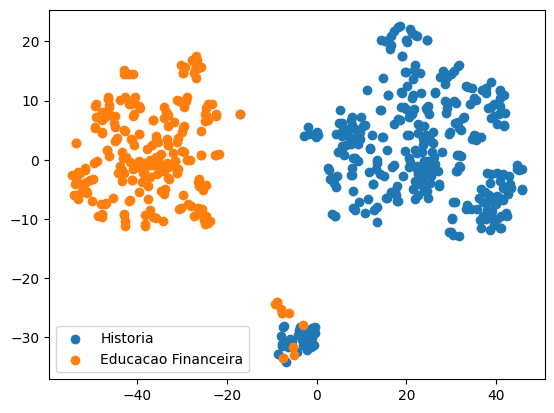

In [13]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.legend()
plt.show()

In [20]:
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split

class Classifier(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
input_size = embedding_size
criterion = nn.CrossEntropyLoss()
classifier = Classifier(input_size, 100, 2)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

X = torch.tensor(all_vectors, dtype=torch.float32)
y = torch.tensor([0]*len(vectors_historia) + [1]*len(vectors_ed_financeira), dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.6949406266212463
Epoch 1 Loss: 0.685396134853363
Epoch 2 Loss: 0.6749990582466125
Epoch 3 Loss: 0.6633157134056091
Epoch 4 Loss: 0.6508335471153259
Epoch 5 Loss: 0.6378770470619202
Epoch 6 Loss: 0.6245384216308594
Epoch 7 Loss: 0.6109175682067871
Epoch 8 Loss: 0.5971515774726868
Epoch 9 Loss: 0.5833649039268494
Epoch 10 Loss: 0.56964510679245
Epoch 11 Loss: 0.5560705065727234
Epoch 12 Loss: 0.5426956415176392
Epoch 13 Loss: 0.5295809507369995
Epoch 14 Loss: 0.5167802572250366
Epoch 15 Loss: 0.5043522715568542
Epoch 16 Loss: 0.4923746585845947
Epoch 17 Loss: 0.4808923602104187
Epoch 18 Loss: 0.46993088722229004
Epoch 19 Loss: 0.45951059460639954
Epoch 20 Loss: 0.44964614510536194
Epoch 21 Loss: 0.4403443932533264
Epoch 22 Loss: 0.4316070079803467
Epoch 23 Loss: 0.4234314262866974
Epoch 24 Loss: 0.41580814123153687
Epoch 25 Loss: 0.4087221920490265
Epoch 26 Loss: 0.40215447545051575
Epoch 27 Loss: 0.3960833251476288
Epoch 28 Loss: 0.39048513770103455
Epoch 29 Loss: 0.3853

In [22]:
from sklearn.metrics import accuracy_score, classification_report

outputs_test = classifier(X_test)
_, predicted = torch.max(outputs_test, 1)

print(accuracy_score(y_test, predicted))

1.0


In [24]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        39

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



## Entropia

In [37]:
def shannon_entropy(p):
    return -np.sum(p * np.log2(p))

all_outputs = classifier(X)
entropy = np.array([shannon_entropy(x) for x in all_outputs.detach().numpy()])
all_chunks = np.array([x.page_content for x in (chunks_historia + chunks_ed_financeira)])

df = pd.DataFrame({"entropy": entropy, 
                   "text": all_chunks, 
                   "label": y.numpy()})

In [48]:
df.sort_values("entropy", ascending=False).head(75)

,entropy,text,label
2,0.999873,Vitória \n2015\nUniVersidade Federal do espíri...,0
435,0.999457,70,1
436,0.997099,71,1
10,0.920177,8,0
506,0.852959,"Há muitos, muitos poucos anos, não existia cel...",1
...,...,...,...
300,0.125863,fície é do tamanho da terra. É muito difícil q...,0
334,0.124060,1\nEducação \nfinancEira\nnas Escolas\nEnsino ...,1
510,0.117494,134,1
241,0.117347,165\nRábano Mauro e Alcuíno de York \ndiante S...,0


In [45]:
df.sort_values("entropy", ascending=True).head(15)

,entropy,text,label
232,0.002472,"158\nEssa filosofia, proveniente do mundo orie...",0
167,0.003102,"118\nséculo xii e inícios do século xiii, o pr...",0
320,0.003274,"224\nfé, filosofia e teologia têm o mesmo obje...",0
134,0.003316,"94\nse satisfaz com os bens finitos, mas almej...",0
224,0.003515,153\nUm autor absolutamente fundamental para s...,0
169,0.003667,119\nEm seus dois comentários as respostas dad...,0
15,0.003962,"pode mais falar de aristotelismo, mas de tomis...",0
168,0.003990,"mso e aristotelismo, o vocabulário estoico do ...",0
269,0.004057,"189\né este amor pela sabedoria, referindo-se ...",0
137,0.004064,"96\nÉ, portanto, a partir desse horizonte unit...",0


In [61]:
df['high_entropy'] = df['entropy'] > 0.2

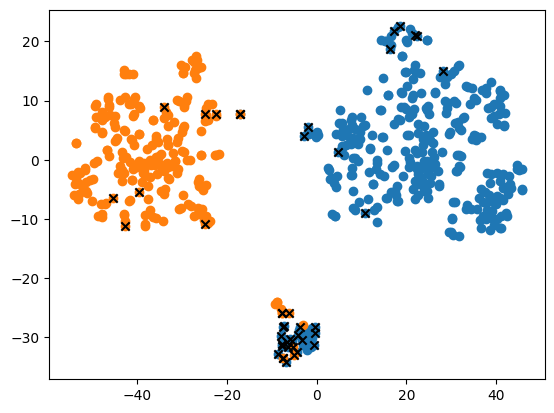

In [62]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.scatter(all_vectors_tsne[df['high_entropy'] == 1, 0], all_vectors_tsne[df['high_entropy'] == 1, 1], label="High Entropy", color="black", marker="x")